In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
animes = pd.read_csv("data/anime.csv")
ratings = pd.read_csv("data/rating.csv")

In [3]:
animes = animes.drop(columns = ['type', 'episodes'], axis = 1)

In [4]:
ratings = ratings[ratings.rating != -1]


In [5]:
animes.dropna(subset = ['rating'], inplace = True)

In [7]:
n_animes = ratings['anime_id'].nunique()
n_animes

9927

In [8]:
ratings.shape

(6337241, 3)

In [9]:
import seaborn as sns

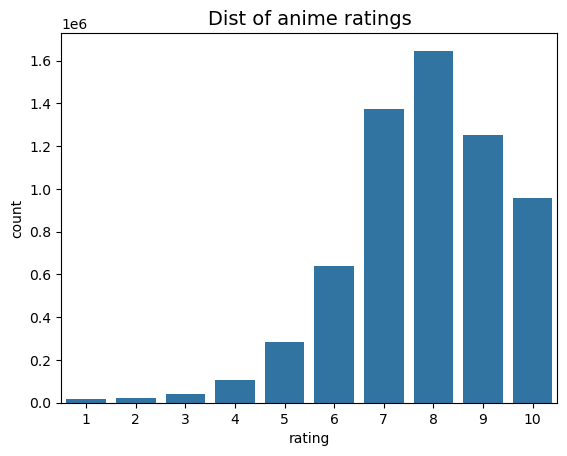

In [10]:
sns.countplot(x = "rating", data = ratings)
plt.title("Dist of anime ratings", fontsize = 14)
plt.show()

In [11]:
##create sparse matrix for filtering
from scipy.sparse import csr_matrix

In [30]:
def create_sparse(ratings):
    userCount = ratings['user_id'].nunique() ##number of unique users
    animeCount = ratings['anime_id'].nunique() ##number of unique animes

    user_map = dict(zip(np.unique(ratings['user_id']), list(range(userCount)))) ##maps each unique user to an index number
    anime_map = dict(zip(np.unique(ratings['anime_id']), list(range(animeCount)))) ##maps each unique anime to an index number

    user_inv_map = dict(zip(list(range(userCount)), np.unique(ratings["user_id"]))) ##reverse mappings for both
    anime_inv_map = dict(zip(list(range(animeCount)), np.unique(ratings['anime_id'])))

    user_index = [user_map[i] for i in ratings['user_id']] ##gets index for each unique user
    anime_index = [anime_map[i] for i in ratings['anime_id']] ##gets index for each unique anime

    sparse = csr_matrix((ratings['rating'], (user_index, anime_index)), shape = (userCount, animeCount))

    return sparse, user_map, anime_map, user_inv_map, anime_inv_map

In [31]:
X, user_mapper, anime_mapper, user_inv_mapper, anime_inv_mapper = create_sparse(ratings)

In [32]:
X.shape

(69600, 9927)

In [33]:
print(X)

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 6337234 stored elements and shape (69600, 9927)>
  Coords	Values
  (0, 5119)	10
  (0, 6290)	10
  (0, 6323)	10
  (0, 6898)	10
  (1, 6329)	10
  (2, 10)	8
  (2, 131)	6
  (2, 147)	9
  (2, 175)	10
  (2, 200)	9
  (2, 315)	6
  (2, 401)	7
  (2, 492)	7
  (2, 515)	7
  (2, 732)	10
  (2, 1015)	7
  (2, 1017)	7
  (2, 1018)	7
  (2, 1026)	8
  (2, 1176)	6
  (2, 1189)	8
  (2, 1379)	7
  (2, 1388)	10
  (2, 1415)	7
  (2, 1530)	8
  :	:
  (69598, 6257)	5
  (69598, 6307)	7
  (69598, 6316)	9
  (69598, 6321)	6
  (69598, 6323)	9
  (69598, 6324)	8
  (69598, 6348)	9
  (69598, 6380)	8
  (69598, 6395)	10
  (69598, 6396)	10
  (69598, 6428)	8
  (69598, 6450)	9
  (69598, 6458)	8
  (69598, 6462)	7
  (69598, 6551)	7
  (69598, 6584)	8
  (69598, 6622)	9
  (69598, 6666)	7
  (69598, 6673)	8
  (69598, 6768)	7
  (69598, 7063)	7
  (69598, 7167)	9
  (69598, 7868)	10
  (69599, 716)	9
  (69599, 5119)	9


In [34]:
##evaluate sparsity
total_elements = X.shape[0] * X.shape[1]
num_ratings = X.nnz
print(num_ratings / total_elements * 100) ##0.9% sparsity

0.9172178164972112


In [35]:
##get ratings/user and ratings/anime
n_ratings_per_user = X.getnnz(axis = 1)
n_ratings_per_anime = X.getnnz(axis = 0)

In [36]:
print(f"Most active user rated {n_ratings_per_user.max()} animes.")
print(f"Least active user rated {n_ratings_per_user.min()} animes.")

Most active user rated 3747 animes.
Least active user rated 1 animes.


In [37]:
print(f"Most rated anime has {n_ratings_per_anime.max()} ratings.")
print(f"Least rated anime has {n_ratings_per_anime.min()} ratings.")

Most rated anime has 34226 ratings.
Least rated anime has 1 ratings.


In [39]:
##Implement KNN to find similar movies
from sklearn.neighbors import NearestNeighbors 

def find_similar_animes(anime_id, X, anime_mapper, anime_inv_mapper, k, metric = "cosine"):
    """
    Finds k-nearest neighbors for anime

    Parameters:
        anime_id: id of anime person wants similar shows to
        X: sparse matrix with all users/ratings
        k: number of neighbors to find
        metric: distance metric(could be euclidean/etc.)
    Output: returns k similar anime Ids
    """
    X = X.T
    neighbor_ids = []

    anime_index = anime_mapper[anime_id] ##gets index of the anime id given for the X matrix
    anime_vector = X[anime_index] ##gets vector of all ratings for given anime id

    if isinstance(anime_vector, (np.ndarray)):
        anime_vector = anime_vector.reshape(1, -1)
    kNN = NearestNeighbors(n_neighbors = k+1, algorithm = "brute", metric = metric)
    kNN.fit(X)
    neighbor = kNN.kneighbors(anime_vector, return_distance = False)
    for i in range(0, k):
        n = neighbor.item(i)
        neighbor_ids.append(anime_inv_mapper[n]) 
    neighbor_ids.pop(0)
    return neighbor_ids

In [44]:
similar_animes = find_similar_animes(20, X, anime_mapper, anime_inv_mapper, k=10)
similar_animes

[1535, 121, 269, 5114, 1575, 11757, 16498, 813, 442]

In [47]:
anime_titles = dict(zip(animes['anime_id'], animes['name']))
anime_id = 20

similar_animes = find_similar_animes(anime_id, X, anime_mapper, anime_inv_mapper, k = 10)
anime_title = anime_titles[anime_id]

print(f"Because you watched {anime_title}:")
for i in similar_animes:
  print(anime_titles[i])

Because you watched Naruto:
Death Note
Fullmetal Alchemist
Bleach
Fullmetal Alchemist: Brotherhood
Code Geass: Hangyaku no Lelouch
Sword Art Online
Shingeki no Kyojin
Dragon Ball Z
Naruto Movie 1: Dai Katsugeki!! Yuki Hime Shinobu Houjou Dattebayo!


In [50]:
##next step -> implement this using titles so they don't have to search by anime id
anime_title_to_id = dict(zip(animes['name'], animes['anime_id']))


In [51]:
import fuzzywuzzy

In [52]:
from fuzzywuzzy import process

def anime_finder(title):
    all_titles = animes['name'].tolist()
    closest_match = process.extractOne(title, all_titles)
    return closest_match[0]

In [53]:
def find_similar_animes(title, X, anime_mapper, anime_inv_mapper, k, metric = "cosine"):
    """
    Finds k-nearest neighbors for anime

    Parameters:
        anime_id: id of anime person wants similar shows to
        X: sparse matrix with all users/ratings
        k: number of neighbors to find
        metric: distance metric(could be euclidean/etc.)
    Output: returns k similar anime Ids
    """
    X = X.T
    neighbor_ids = []

    actualTitle = anime_finder(title)
    anime_id = anime_title_to_id[actualTitle]
    anime_index = anime_mapper[anime_id] ##gets index of the anime id given for the X matrix
    anime_vector = X[anime_index] ##gets vector of all ratings for given anime id

    if isinstance(anime_vector, (np.ndarray)):
        anime_vector = anime_vector.reshape(1, -1)
    kNN = NearestNeighbors(n_neighbors = k+1, algorithm = "brute", metric = metric)
    kNN.fit(X)
    neighbor = kNN.kneighbors(anime_vector, return_distance = False)
    for i in range(0, k):
        n = neighbor.item(i)
        neighbor_ids.append(anime_inv_mapper[n]) 
    neighbor_ids.pop(0)
    return neighbor_ids

In [55]:
similar_animes = find_similar_animes("Naruto", X, anime_mapper, anime_inv_mapper, k=10)
similar_animes

[1535, 121, 269, 5114, 1575, 11757, 16498, 813, 442]

In [56]:
print("Because you watched Naruto:")
for i in similar_animes:
  print(anime_titles[i])

Because you watched Naruto:
Death Note
Fullmetal Alchemist
Bleach
Fullmetal Alchemist: Brotherhood
Code Geass: Hangyaku no Lelouch
Sword Art Online
Shingeki no Kyojin
Dragon Ball Z
Naruto Movie 1: Dai Katsugeki!! Yuki Hime Shinobu Houjou Dattebayo!
